In [1]:
import numpy as np
from utils import (
    aggregate_steps,
    extract_ndy,
    filter_zero_d,
    fit_power_law,
    plot_actual_vs_predicted,
    plot_fit,
    predict_power_law,
    pull_metrics_from_wandb,
)

/Users/nikilravi/miniconda3/envs/crfm_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-24 02:07:45,854	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
ENTITY = "stanford-mercury"
PROJECT = "marin"

# define the list of smaller runs to use as "ladder" models
RUNS = [
    "tootsie-scaling-512-81c36c",
    "tootsie-scaling-768-d17a90",
    "tootsie-scaling-1024-f4e4be",
    "tootsie-scaling-1536-e2a6d8",
    "tootsie-scaling-2048-72c648",
]

# the large run to predict the performance of
PRED_RUN = "llama-8b-tootsie-0.001-19ad63"

# define the eval task loss metric
TASK_LOSS = "eval/paloma/c4_en/bpb"
# TASK_LOSS = "internal_eval/mmlu/bpb"

# do we want to take the last step of the run or average over all steps, or just use all steps?
AGGREGATION = "all"

TOKENS_COL = "throughput/total_tokens"
PARAM_COL = "parameter_count"

In [3]:
ladder_df = pull_metrics_from_wandb(
    runs=RUNS,
    metrics=[TASK_LOSS, TOKENS_COL],
    entity=ENTITY,
    project=PROJECT,
    summary_fields=[PARAM_COL]
)

Computed params: 248791040
Computed params: 461266944
Computed params: 732463104
Computed params: 1451016192
Computed params: 2337341440


In [4]:
ladder_df

,eval/paloma/c4_en/bpb,throughput/total_tokens,run,computed_params,parameter_count,step
0,3.755196,0.000000e+00,tootsie-scaling-512-81c36c,248791040,248791552,0
1,1.039921,4.194304e+10,tootsie-scaling-512-81c36c,248791040,248791552,1
2,1.024333,8.388608e+10,tootsie-scaling-512-81c36c,248791040,248791552,2
3,1.018965,1.258291e+11,tootsie-scaling-512-81c36c,248791040,248791552,3
4,1.013399,1.677722e+11,tootsie-scaling-512-81c36c,248791040,248791552,4
5,1.000790,2.097110e+11,tootsie-scaling-512-81c36c,248791040,248791552,5
6,3.763502,0.000000e+00,tootsie-scaling-768-d17a90,461266944,461267712,0
7,0.987020,4.194304e+10,tootsie-scaling-768-d17a90,461266944,461267712,1
8,0.969680,8.388608e+10,tootsie-scaling-768-d17a90,461266944,461267712,2
9,0.962653,1.258291e+11,tootsie-scaling-768-d17a90,461266944,461267712,3


In [5]:
ladder_df["computed_params"] - ladder_df[PARAM_COL]

0     -512
1     -512
2     -512
3     -512
4     -512
5     -512
6     -768
7     -768
8     -768
9     -768
10    -768
11    -768
12   -1024
13   -1024
14   -1024
15   -1024
16   -1024
17   -1536
18   -1536
19   -1536
20   -1536
21   -1536
22   -2048
23   -2048
24   -2048
25   -2048
26   -2048
27   -2048
dtype: int64

In [ ]:
ladder_df_filtered = filter_zero_d(ladder_df, TOKENS_COL)
ladder_df_agg = aggregate_steps(ladder_df_filtered, step_mode=AGGREGATION)

In [ ]:
N, D, y = extract_ndy(ladder_df_agg, PARAM_COL, TOKENS_COL, TASK_LOSS)
N = N / np.mean(N)
D = D / np.mean(D)
N_scale = np.mean(N)  # Save the mean of N
D_scale = np.mean(D)  # Save the mean of D
params = fit_power_law(N, D, y, use_log_space=True)
print("Fitted params (small runs):", params)
preds = predict_power_law(params, N, D)


N: [ 248791552  248791552  248791552  248791552  248791552  461267712
  461267712  461267712  461267712  461267712  732464128  732464128
  732464128  732464128 1451017728 1451017728 1451017728 1451017728
 2337343488 2337343488 2337343488 2337343488 2337343488]
hidden_dim: 1      512
2      512
3      512
4      512
5      512
7      768
8      768
9      768
10     768
11     768
13    1024
14    1024
15    1024
16    1024
18    1536
19    1536
20    1536
21    1536
23    2048
24    2048
25    2048
26    2048
27    2048
Name: 0, dtype: int64
After non-embedding params
N: 1      117457408
2      117457408
3      117457408
4      117457408
5      117457408
7      264266496
8      264266496
9      264266496
10     264266496
11     264266496
13     469795840
14     469795840
15     469795840
16     469795840
18    1057015296
19    1057015296
20    1057015296
21    1057015296
23    1812006912
24    1812006912
25    1812006912
26    1812006912
27    1812006912
Name: 0, dtype: int64
Fitted pa

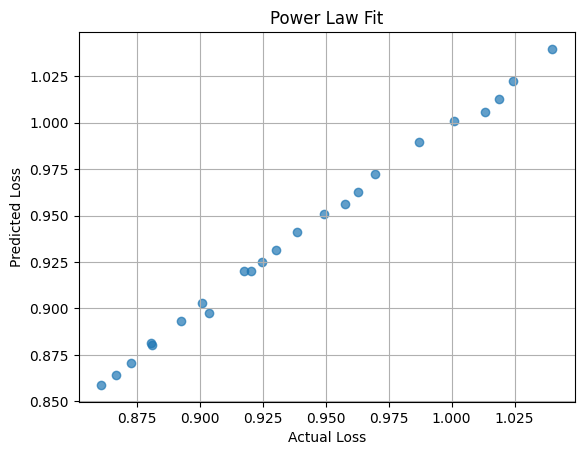

In [ ]:
plot_fit(y, preds, "Power Law Fit")

In [ ]:
pred_df = pull_metrics_from_wandb(
    runs=[PRED_RUN],
    metrics=[TASK_LOSS, TOKENS_COL],
    entity=ENTITY,
    project=PROJECT,
    summary_fields=[PARAM_COL]
)
pred_df_filtered = filter_zero_d(pred_df, d_key=TOKENS_COL)

pred_df_filtered


,eval/paloma/c4_en/bpb,throughput/total_tokens,run,parameter_count,step
1,0.880757,2.097152e+10,llama-8b-tootsie-0.001-19ad63,8030261248,1
2,0.848793,4.194304e+10,llama-8b-tootsie-0.001-19ad63,8030261248,2
3,0.835961,6.291456e+10,llama-8b-tootsie-0.001-19ad63,8030261248,3
4,0.828110,8.388608e+10,llama-8b-tootsie-0.001-19ad63,8030261248,4
5,0.823020,1.048576e+11,llama-8b-tootsie-0.001-19ad63,8030261248,5
6,0.818820,1.258291e+11,llama-8b-tootsie-0.001-19ad63,8030261248,6
7,0.816417,1.468006e+11,llama-8b-tootsie-0.001-19ad63,8030261248,7
8,0.813680,1.677722e+11,llama-8b-tootsie-0.001-19ad63,8030261248,8
9,0.812240,1.887437e+11,llama-8b-tootsie-0.001-19ad63,8030261248,9
10,0.810790,2.097152e+11,llama-8b-tootsie-0.001-19ad63,8030261248,10


In [ ]:
pred_df_agg = aggregate_steps(pred_df_filtered, step_mode=AGGREGATION)
N_pred, D_pred, y_pred = extract_ndy(pred_df_agg, PARAM_COL, TOKENS_COL, TASK_LOSS)

N_pred = N_pred / N_scale
D_pred = D_pred / D_scale

preds_big = predict_power_law(params, N_pred, D_pred)

print(N_pred)
print(D_pred)
print(y_pred)

N: [8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248 8030261248 8030261248 8030261248 8030261248 8030261248
 8030261248]
hidden_dim: 1     8
2     8
3     8
4     8
5     8
6     8
7     8
8     8
9     8
10    8
11    8
12    8
13    8
14    8
15    8
16    8
17    8
18    8
19    8
20    8
21    8
22    8
23    8
24    8
25    8
26    8
27    8
28    8
29    8
30    8
31    8
32    8
33    8
34    8
35    8
36    8
37    8
38    8
39    8
40    8
41    8
42    8
43    8
44    8
45    8
46    8
4

In [ ]:
print("\nPrediction on bigger run:")
for actual, pred in zip(y_pred, preds_big, strict=False):
    print(f"  Actual: {actual:.4f}  |  Predicted: {pred:.4f}")


Prediction on bigger run:
  Actual: 0.8808  |  Predicted: 0.4139
  Actual: 0.8488  |  Predicted: 0.4116
  Actual: 0.8360  |  Predicted: 0.4104
  Actual: 0.8281  |  Predicted: 0.4095
  Actual: 0.8230  |  Predicted: 0.4088
  Actual: 0.8188  |  Predicted: 0.4083
  Actual: 0.8164  |  Predicted: 0.4079
  Actual: 0.8137  |  Predicted: 0.4075
  Actual: 0.8122  |  Predicted: 0.4072
  Actual: 0.8108  |  Predicted: 0.4069
  Actual: 0.8088  |  Predicted: 0.4066
  Actual: 0.8080  |  Predicted: 0.4064
  Actual: 0.8067  |  Predicted: 0.4061
  Actual: 0.8062  |  Predicted: 0.4059
  Actual: 0.8052  |  Predicted: 0.4058
  Actual: 0.8046  |  Predicted: 0.4056
  Actual: 0.8036  |  Predicted: 0.4054
  Actual: 0.8024  |  Predicted: 0.4053
  Actual: 0.8018  |  Predicted: 0.4051
  Actual: 0.8009  |  Predicted: 0.4050
  Actual: 0.8012  |  Predicted: 0.4049
  Actual: 0.8002  |  Predicted: 0.4047
  Actual: 0.7999  |  Predicted: 0.4046
  Actual: 0.8000  |  Predicted: 0.4045
  Actual: 0.7989  |  Predicted: 0.404

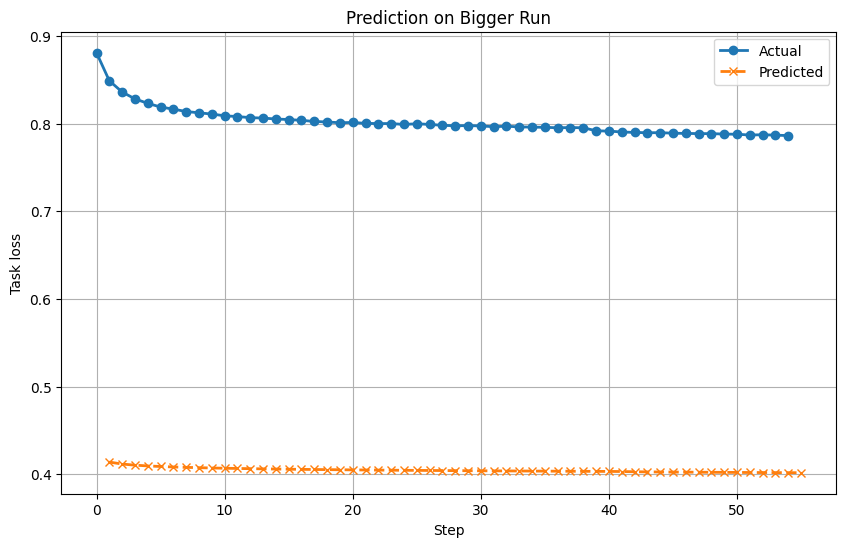

In [ ]:
plot_actual_vs_predicted(y_pred, preds_big, title="Prediction on Bigger Run")